In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.patches as mpatches
import warnings
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp
import seaborn as sns

warnings.filterwarnings("ignore")

### EDA(Concept drift)

In [5]:
df = pd.read_csv('./경진대회용 주조 공정최적화 데이터셋.csv', encoding = 'euc-kr', index_col = 0)
df.drop(['line','name','mold_name','molten_volume','heating_furnace','emergency_stop','tryshot_signal','working'], axis=1, inplace=True)
df.dropna(subset=['passorfail', 'upper_mold_temp3','molten_temp'], inplace=True)
df['datetime'] = pd.to_datetime(df['time'] + ' ' + df['date'])

start_date = pd.to_datetime('2019-01-02 16:45')
interval_date = pd.to_datetime('2019-01-16 20:00:00')
end_date = pd.to_datetime('2019-03-31 23:59:59')
regular_intervals = pd.date_range(start=interval_date, end='2019-03-17 20:00:00', freq='2W')

date_range = [start_date] + list(regular_intervals) + [end_date]
df['week_range'] = pd.cut(df['datetime'], bins=date_range, labels=['week'+str(i) for i in range(1,7)])

columns_of_interest = ['facility_operation_cycleTime', 'production_cycletime', 'low_section_speed', 'molten_temp',
                       'high_section_speed','cast_pressure', 'biscuit_thickness', 'upper_mold_temp1',
                       'upper_mold_temp2', 'upper_mold_temp3','lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3','sleeve_temperature',
                       'physical_strength', 'Coolant_temperature', 'EMS_operation_time','passorfail', 'week_range']

df = df[columns_of_interest]
display(df)

facility_operation_cycleTime  production_cycletime  low_section_speed  \
0                               119                   120              110.0   
22                              119                   120              109.0   
24                              119                   123              109.0   
26                              119                   124              109.0   
28                              120                   124              110.0   
...                             ...                   ...                ...   
92010                           122                   122              100.0   
92011                           120                   121              100.0   
92012                           122                   135              100.0   
92013                           133                   122              100.0   
92014                           122                   123              100.0   

       molten_temp  high_section_speed  cast_pressure  biscuit_thickness  \
0            731.0               112.0          331.0               35.0   
22           731.0               125.0          177.0               48.0   
24           731.0               112.0          176.0               49.0   
26           731.0               112.0          331.0               47.0   
28           731.0               112.0          331.0               46.0   
...            ...                 ...            ...                ...   
92010        731.0               101.0          331.0               49.0   
92011        731.0               101.0          331.0               54.0   
92012        732.0               101.0          331.0               52.0   
92013        732.0               101.0          331.0               53.0   
92014        732.0               101.0          331.0               56.0   

       upper_mold_temp1  upper_mold_temp2  upper_mold_temp3  lower_mold_temp1  \
0                 198.0             116.0            1449.0             234.0   
22                 24.0              33.0            1449.0              30.0   
24                 26.0              55.0            1449.0              30.0   
26                 31.0              65.0            1449.0              30.0   
28                 36.0              73.0            1449.0              31.0   
...                 ...               ...               ...               ...   
92010              83.0             183.0            1449.0             231.0   
92011              83.0             184.0            1449.0             232.0   
92012              79.0             184.0            1449.0             225.0   
92013              82.0             185.0            1449.0             227.0   
92014              84.0             185.0            1449.0             228.0   

       lower_mold_temp2  lower_mold_temp3  sleeve_temperature  \
0                 316.0            1449.0               550.0   
22                273.0            1449.0               479.0   
24                323.0            1449.0               513.0   
26                343.0            1449.0               531.0   
28                343.0            1449.0               544.0   
...                 ...               ...                 ...   
92010             201.0            1449.0               279.0   
92011             201.0            1449.0               279.0   
92012             195.0            1449.0               272.0   
92013             199.0            1449.0               288.0   
92014             200.0            1449.0               289.0   

       physical_strength  Coolant_temperature  EMS_operation_time  passorfail  \
0                  700.0                 34.0                  23         0.0   
22                 708.0                 35.0                  23         1.0   
24                 700.0                 35.0                  23         1.0   
26                 708.0                 34.0          

upper_mold_temp1: 80 above UCL, 81 below LCL
upper_mold_temp2: 68 above UCL, 90 below LCL
upper_mold_temp3: 0 above UCL, 83 below LCL
lower_mold_temp1: 89 above UCL, 90 below LCL
lower_mold_temp2: 75 above UCL, 88 below LCL
lower_mold_temp3: 1 above UCL, 89 below LCL
sleeve_temperature: 74 above UCL, 87 below LCL
Coolant_temperature: 77 above UCL, 56 below LCL
EMS_operation_time: 0 above UCL, 0 below LCL


<Figure size 2560x1920 with 0 Axes>

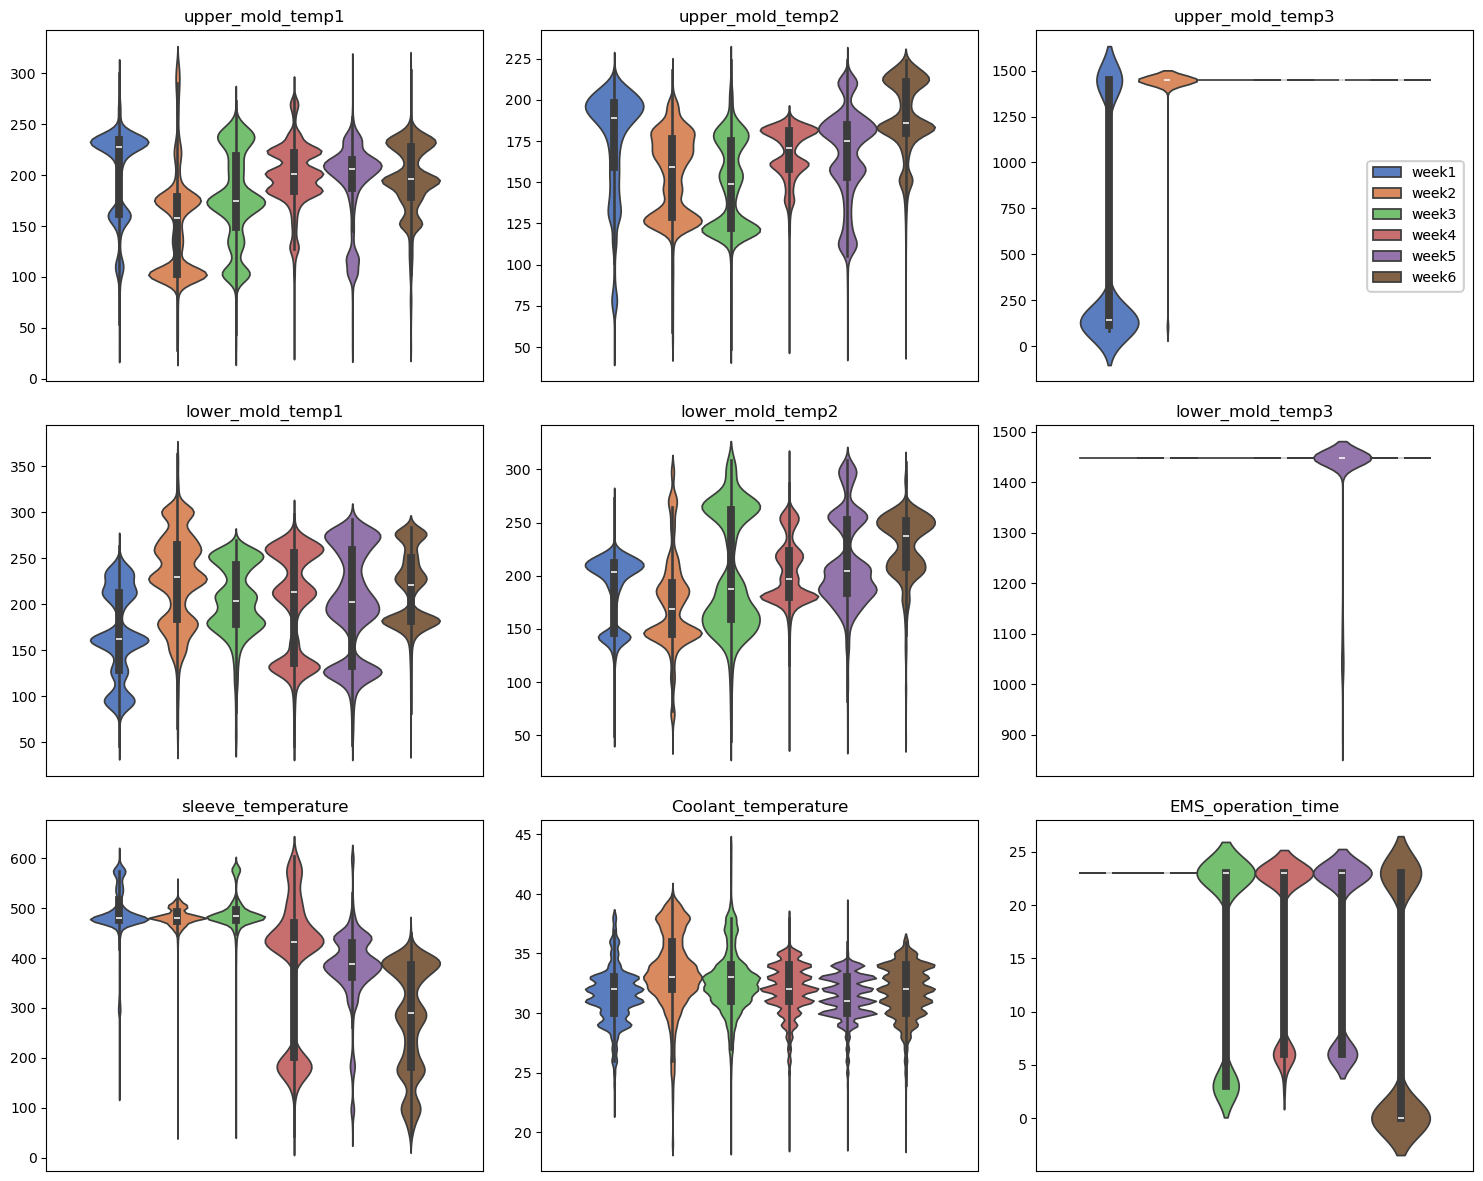

In [6]:
variables = ['upper_mold_temp1','upper_mold_temp2','upper_mold_temp3','lower_mold_temp1','lower_mold_temp2','lower_mold_temp3','sleeve_temperature','Coolant_temperature','EMS_operation_time']
df['week_range'] = pd.Categorical(df['week_range'], categories=['week1', 'week2', 'week3','week4','week5','week6'], ordered=True)

n_cols = 3
n_rows = (len(variables) + n_cols - 1) // n_cols

plt.figure(dpi=400)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))
fig.tight_layout()

for i, col in enumerate(variables):
    if col in ['passorfail','mold_code','count']:
        continue

    UCL_dict = {}
    LCL_dict = {}
    outliers_count = {}

    UCL_dict[col] = np.percentile(df[col], 99.9)
    LCL_dict[col] = np.percentile(df[col], 0.1)

    num_outliers_above = (df[col] > UCL_dict[col]).sum()
    num_outliers_below = (df[col] < LCL_dict[col]).sum()

    outliers_count[col] = num_outliers_above + num_outliers_below

    print(f'{col}: {num_outliers_above} above UCL, {num_outliers_below} below LCL')
    df_temp_filtered = df[(df[col] <= UCL_dict[col]) & (df[col] >= LCL_dict[col])]

    row, var = divmod(i, n_cols)
    sns.violinplot(data=df_temp_filtered, y=col, hue='week_range', ax=axes[row, var], palette='muted')
    axes[row, var].set_title(f'{col}')
    axes[row, var].set_xticks([])
    axes[row, var].set_ylabel("")
    axes[row, var].get_legend().remove()

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(0.98, 0.88))

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flat[j])

plt.show()

- 시간이 지날수록(week 진행), 각 변수의 분포가 변하는 것을 확인 가능

--------------------

### 시간에 따른 DecisionBoundary 변화 시각화

In [9]:
df = pd.read_csv('./경진대회용 주조 공정최적화 데이터셋.csv', encoding = 'euc-kr', index_col = 0)
df.dropna(subset=['emergency_stop', 'upper_mold_temp3','lower_mold_temp3'], inplace=True)
df = df[['facility_operation_cycleTime','production_cycletime', 'low_section_speed', 'high_section_speed','cast_pressure', 'biscuit_thickness',
       'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3','lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3','sleeve_temperature', 'physical_strength', 'Coolant_temperature',
       'EMS_operation_time','passorfail']]
display(df)

facility_operation_cycleTime  production_cycletime  low_section_speed  \
0                               119                   120              110.0   
22                              119                   120              109.0   
24                              119                   123              109.0   
26                              119                   124              109.0   
28                              120                   124              110.0   
...                             ...                   ...                ...   
92010                           122                   122              100.0   
92011                           120                   121              100.0   
92012                           122                   135              100.0   
92013                           133                   122              100.0   
92014                           122                   123              100.0   

       high_section_speed  cast_pressure  biscuit_thickness  upper_mold_temp1  \
0                   112.0          331.0               35.0             198.0   
22                  125.0          177.0               48.0              24.0   
24                  112.0          176.0               49.0              26.0   
26                  112.0          331.0               47.0              31.0   
28                  112.0          331.0               46.0              36.0   
...                   ...            ...                ...               ...   
92010               101.0          331.0               49.0              83.0   
92011               101.0          331.0               54.0              83.0   
92012               101.0          331.0               52.0              79.0   
92013               101.0          331.0               53.0              82.0   
92014               101.0          331.0               56.0              84.0   

       upper_mold_temp2  upper_mold_temp3  lower_mold_temp1  lower_mold_temp2  \
0                 116.0            1449.0             234.0             316.0   
22                 33.0            1449.0              30.0             273.0   
24                 55.0            1449.0              30.0             323.0   
26                 65.0            1449.0              30.0             343.0   
28                 73.0            1449.0              31.0             343.0   
...                 ...               ...               ...               ...   
92010             183.0            1449.0             231.0             201.0   
92011             184.0            1449.0             232.0             201.0   
92012             184.0            1449.0             225.0             195.0   
92013             185.0            1449.0             227.0             199.0   
92014             185.0            1449.0             228.0             200.0   

       lower_mold_temp3  sleeve_temperature  physical_strength  \
0                1449.0               550.0              700.0   
22               1449.0               479.0              708.0   
24               1449.0               513.0              700.0   
26               1449.0               531.0              708.0   
28               1449.0               544.0              707.0   
...                 ...                 ...                ...   
92010            1449.0               279.0              726.0   
92011            1449.0               279.0              732.0   
92012            1449.0               272.0              731.0   
92013            1449.0               288.0              723.0   
92014            1449.0               289.0              705.0   

       Coolant_temperature  EMS_operation_time  passorfail  
0                     34.0                  23         0.0  
22                    35.0                  23         1.0  
24                    35.0                  23         1.0  
26                    34.0                  23         1.0  
28

In [10]:
chunk_num = 9
chunk_size = len(df) // chunk_num
chunk_li = []

for i in range(chunk_num):
    start_idx = i*chunk_size
    end_idx = (i+1)*chunk_size
    if i == (chunk_num-1):
        chunk_df = df.iloc[start_idx:,:]
    else:
        chunk_df = df.iloc[start_idx:end_idx,:]
    chunk_li.append(chunk_df)

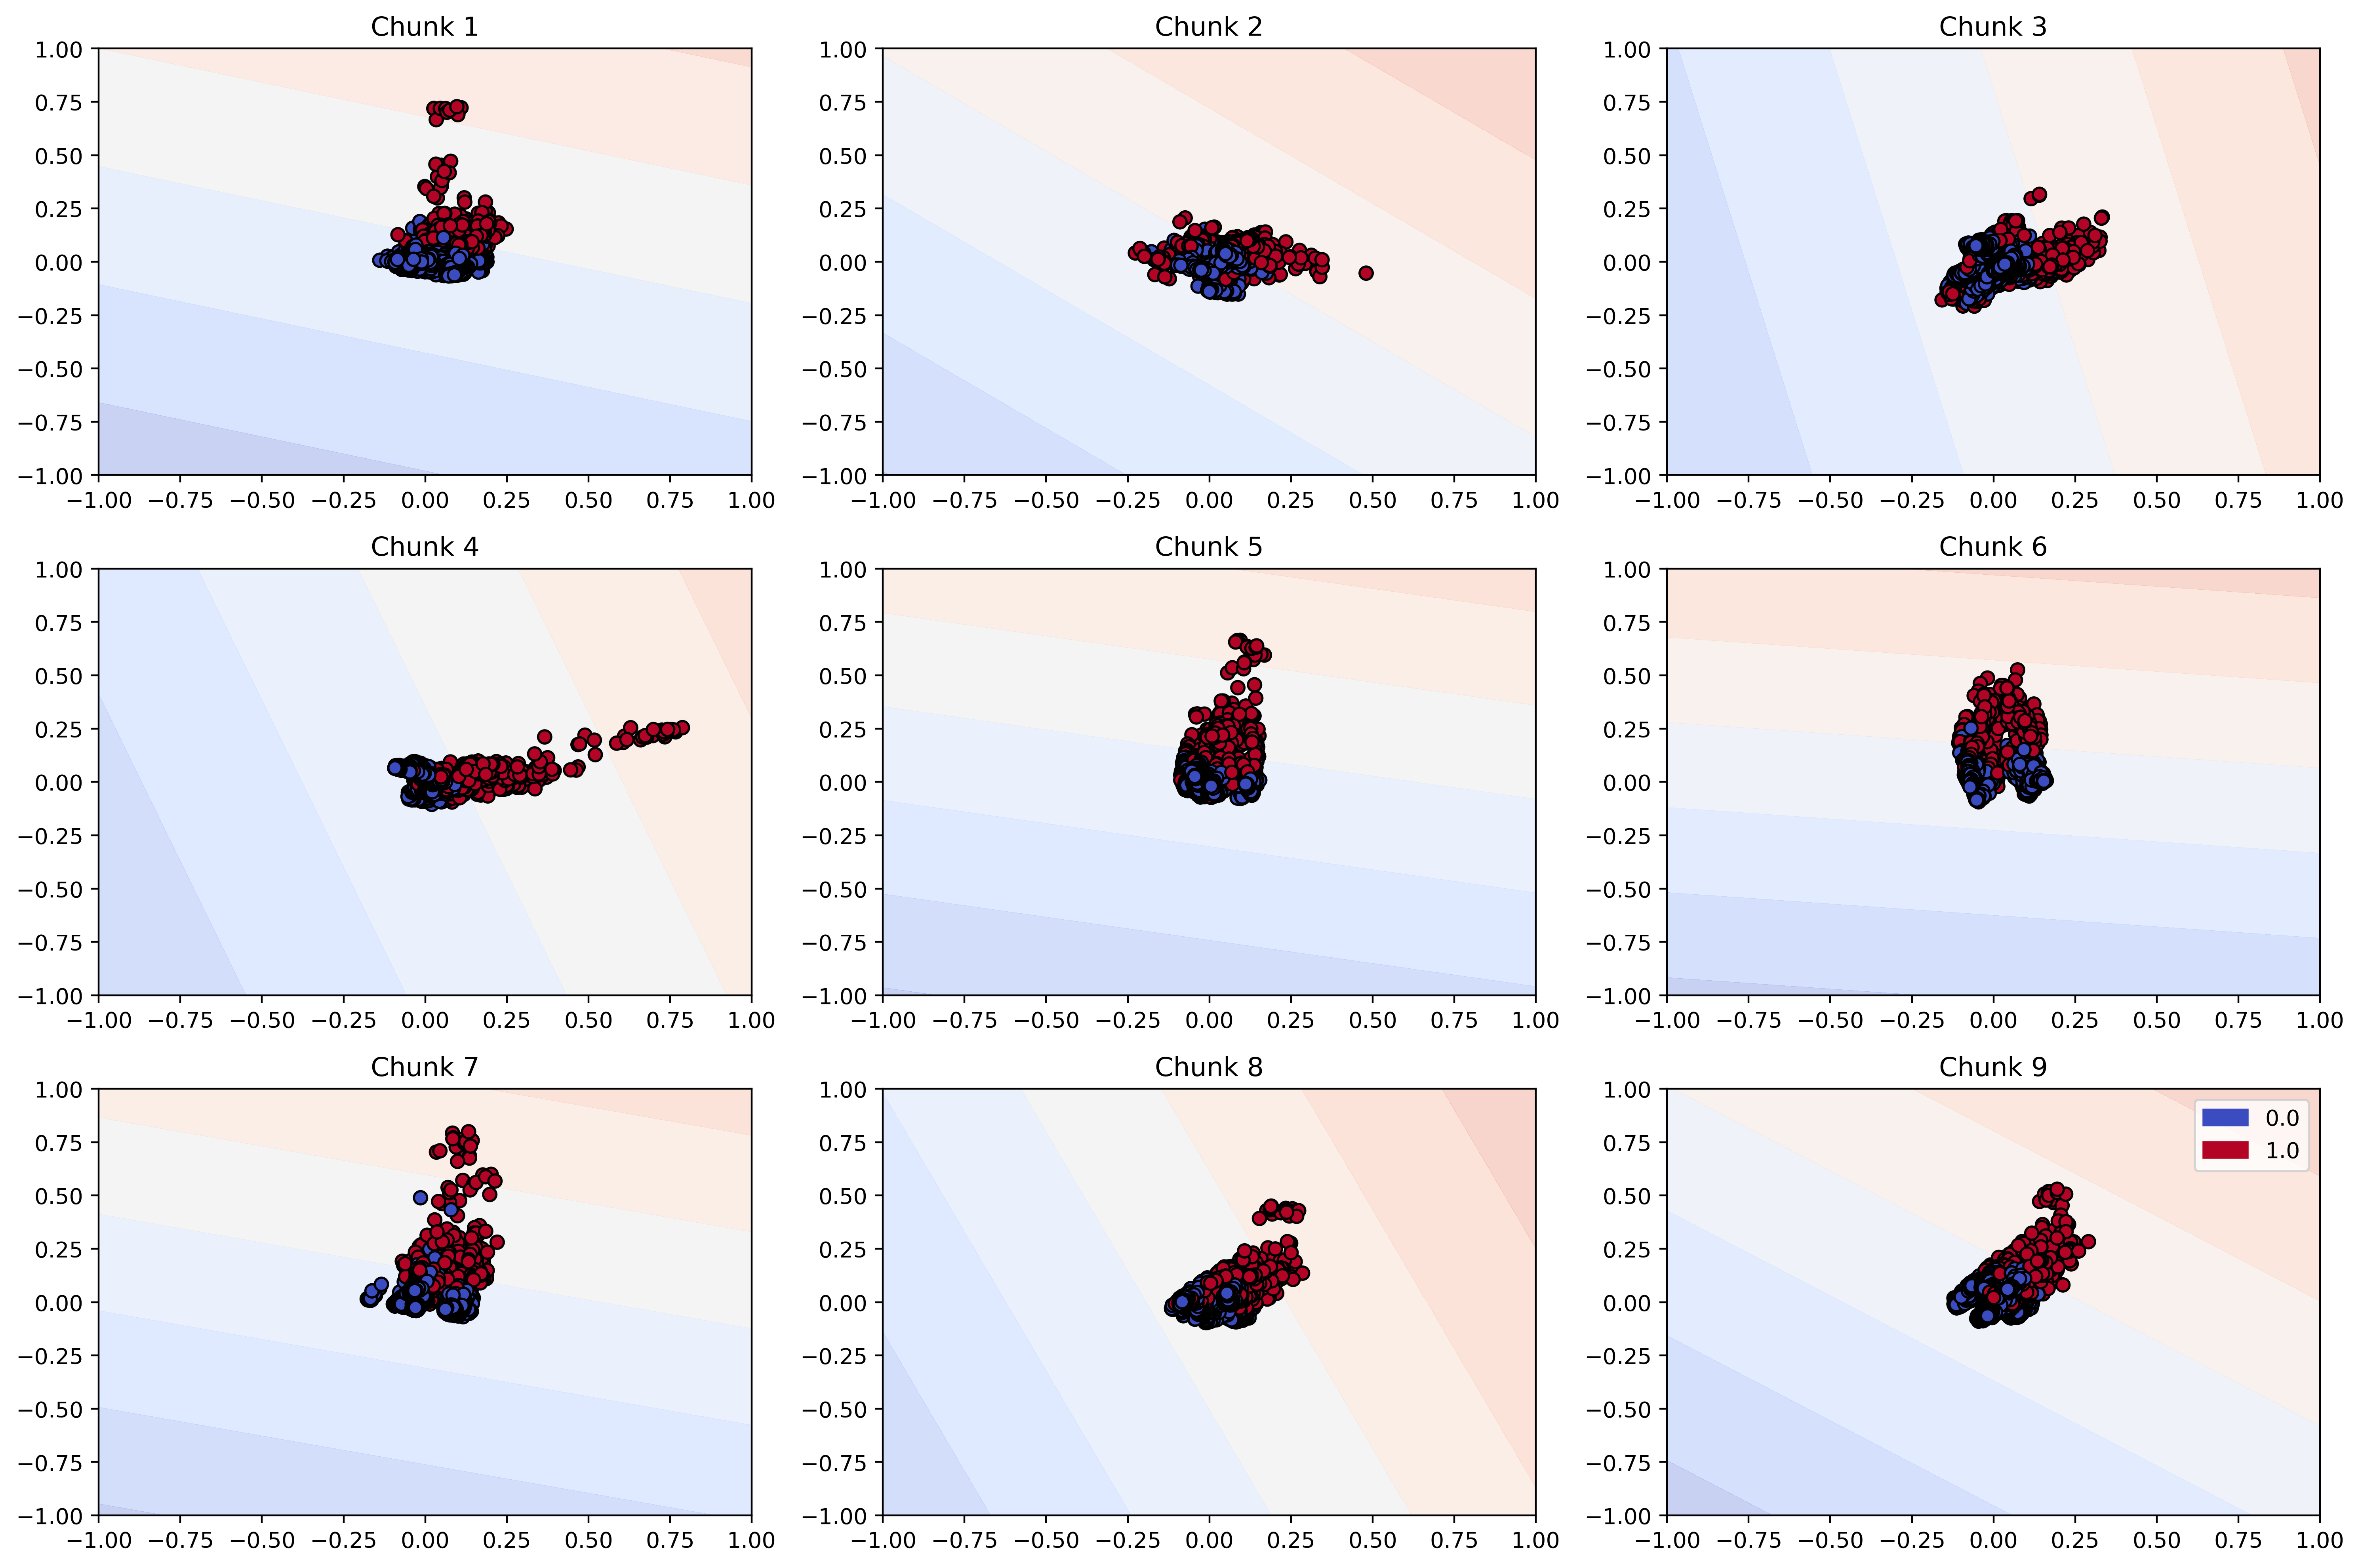

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), dpi=400)
axes = axes.ravel()

for i, df in enumerate(chunk_li):

    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0008)
    X_kpca = kpca.fit_transform(X_scaled)

    svm = SVC(kernel='linear')
    svm.fit(X_kpca, y)

    ax = axes[i]
    DecisionBoundaryDisplay.from_estimator(svm, X_kpca, ax=ax, cmap='coolwarm', alpha=0.3)

    scatter = ax.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y, cmap='coolwarm', edgecolor='k')

    ax.set_title(f"Chunk {i + 1}")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    unique_labels = ['pass','fail']
    if i == 8:
      unique_labels = np.unique(y)
      legend_patches = [mpatches.Patch(color=scatter.cmap(scatter.norm(label)), label=f"{n}") for label,n in enumerate(unique_labels)]
      ax.legend(handles=legend_patches)

plt.tight_layout()
plt.show()

### Model Comparison

In [12]:
arf_result = pd.read_csv('./test_results/20190130_0800_RF_result(400,0.5,0.85).csv', index_col = 0)
mlp_result = pd.read_csv('./test_results/20190130_0800_MLP_result(400,0.5,0.85).csv', index_col = 0)
onn_result_off = pd.read_csv('./test_results/Offline_ONN_results.csv')
onn_result_on = pd.read_csv('./test_results/Online_ONN_results.csv')
rf_result = pd.read_csv('./test_results/Offline_RF_results.csv')

In [13]:
onn_result = pd.DataFrame(columns=['online_pred','offline_pred','ground_truth'])
onn_result['online_pred'] = onn_result_on['Prediction']
onn_result['offline_pred'] = onn_result_off['Prediction']
onn_result['ground_truth'] = onn_result_on['Actual']

In [14]:
print("Accuracy")
print("Offline")
print("RF:", accuracy_score(arf_result['ground_truth'], rf_result['Prediction']))
print("Adaptive RF:", accuracy_score(arf_result['ground_truth'], arf_result['offline_pred']))
print("MLP:", accuracy_score(arf_result['ground_truth'], mlp_result['offline_pred']))
print("ONN:", accuracy_score(arf_result['ground_truth'], onn_result['offline_pred']))
print("Online")
print("Adaptive RF:", accuracy_score(arf_result['ground_truth'], arf_result['online_pred']))
print("MLP:", accuracy_score(arf_result['ground_truth'], mlp_result['online_pred']))
print("ONN:", accuracy_score(arf_result['ground_truth'], onn_result['online_pred']))

Accuracy
Offline
RF: 0.8976563817231495
Adaptive RF: 0.9659110068821753
MLP: 0.9458316089575574
ONN: 0.8566239021474227
Online
Adaptive RF: 0.9831854202112169
MLP: 0.9823270642694012
ONN: 0.9819745252218697


In [15]:
print("Balanced accuracy")
print("Offline")
print("RF:", balanced_accuracy_score(arf_result['ground_truth'], rf_result['Prediction']))
print("Adaptive RF:", balanced_accuracy_score(arf_result['ground_truth'], arf_result['offline_pred']))
print("MLP:", balanced_accuracy_score(arf_result['ground_truth'], mlp_result['offline_pred']))
print("ONN:", balanced_accuracy_score(arf_result['ground_truth'], onn_result['offline_pred']))
print("Online")
print("Adaptive RF:", balanced_accuracy_score(arf_result['ground_truth'], arf_result['online_pred']))
print("MLP:", balanced_accuracy_score(arf_result['ground_truth'], mlp_result['online_pred']))
print("ONN:", balanced_accuracy_score(arf_result['ground_truth'], onn_result['online_pred']))

Balanced accuracy
Offline
RF: 0.8121745546193067
Adaptive RF: 0.7935405663223332
MLP: 0.8540597430679466
ONN: 0.8265506102407632
Online
Adaptive RF: 0.8194251629791258
MLP: 0.8653892861233367
ONN: 0.863057626689379


In [16]:
print("F1 Score")
print("Offline")
print("RF:", f1_score(arf_result['ground_truth'], rf_result['Prediction']))
print("Adaptive RF:", f1_score(arf_result['ground_truth'], arf_result['offline_pred']))
print("MLP:", f1_score(arf_result['ground_truth'], mlp_result['offline_pred']))
print("ONN:", f1_score(arf_result['ground_truth'], onn_result['offline_pred']))
print("Online")
print("Adaptive RF:", f1_score(arf_result['ground_truth'], arf_result['online_pred']))
print("MLP:", f1_score(arf_result['ground_truth'], mlp_result['online_pred']))
print("ONN:", f1_score(arf_result['ground_truth'], onn_result['online_pred']))

F1 Score
Offline
RF: 0.38318706697459587
Adaptive RF: 0.6107805390269514
MLP: 0.5517503805175038
ONN: 0.32878874856486795
Online
Adaptive RF: 0.7710290127322063
MLP: 0.7868367535588834
ONN: 0.7824639289678136


In [17]:
chunk_num = 30
chunk_size = len(arf_result) // chunk_num

offarf_acc_list = []
offmlp_acc_list = []
offonn_acc_list = []
onarf_acc_list = []
onmlp_acc_list = []
ononn_acc_list = []

offarf_f1_list = []
offmlp_f1_list = []
offonn_f1_list = []
onarf_f1_list = []
onmlp_f1_list = []
ononn_f1_list = []

for i in range(chunk_num):
    start_idx = i*chunk_size
    end_idx = (i+1)*chunk_size
    if i == (chunk_num-1):
        chunk_y = arf_result.loc[start_idx:,'ground_truth']
        chunk_pred_off_arf = arf_result.loc[start_idx:,'offline_pred']
        chunk_pred_on_arf = arf_result.loc[start_idx:,'online_pred']
        chunk_pred_off_mlp = mlp_result.loc[start_idx:,'offline_pred']
        chunk_pred_on_mlp = mlp_result.loc[start_idx:,'online_pred']
        chunk_pred_off_onn = onn_result.loc[start_idx:,'offline_pred']
        chunk_pred_on_onn = onn_result.loc[start_idx:,'online_pred']
    else:
        chunk_y = arf_result.loc[start_idx:end_idx,'ground_truth']
        chunk_pred_off_arf = arf_result.loc[start_idx:end_idx,'offline_pred']
        chunk_pred_on_arf = arf_result.loc[start_idx:end_idx,'online_pred']
        chunk_pred_off_mlp = mlp_result.loc[start_idx:end_idx,'offline_pred']
        chunk_pred_on_mlp = mlp_result.loc[start_idx:end_idx,'online_pred']
        chunk_pred_off_onn = onn_result.loc[start_idx:end_idx,'offline_pred']
        chunk_pred_on_onn = onn_result.loc[start_idx:end_idx,'online_pred']

    offarf_acc_list.append(balanced_accuracy_score(chunk_y,chunk_pred_off_arf))
    offmlp_acc_list.append(balanced_accuracy_score(chunk_y,chunk_pred_off_mlp))
    offonn_acc_list.append(balanced_accuracy_score(chunk_y,chunk_pred_off_onn))
    onarf_acc_list.append(balanced_accuracy_score(chunk_y,chunk_pred_on_arf))
    onmlp_acc_list.append(balanced_accuracy_score(chunk_y,chunk_pred_on_mlp))
    ononn_acc_list.append(balanced_accuracy_score(chunk_y,chunk_pred_on_onn))

    offarf_f1_list.append(f1_score(chunk_y, chunk_pred_off_arf))
    offmlp_f1_list.append(f1_score(chunk_y, chunk_pred_off_mlp))
    offonn_f1_list.append(f1_score(chunk_y, chunk_pred_off_onn))
    onarf_f1_list.append(f1_score(chunk_y, chunk_pred_on_arf))
    onmlp_f1_list.append(f1_score(chunk_y, chunk_pred_on_mlp))
    ononn_f1_list.append(f1_score(chunk_y, chunk_pred_on_onn))

total_acc_perf = pd.DataFrame()
total_acc_perf['Offline_ARF'] = offarf_acc_list
total_acc_perf['Offline_MLP'] = offmlp_acc_list
total_acc_perf['Offline_ONN'] = offonn_acc_list
total_acc_perf['Online_ARF'] = onarf_acc_list
total_acc_perf['Online_MLP'] = onmlp_acc_list
total_acc_perf['Online_ONN'] = ononn_acc_list

total_f1_perf = pd.DataFrame()
total_f1_perf['Offline_ARF'] = offarf_f1_list
total_f1_perf['Offline_MLP'] = offmlp_f1_list
total_f1_perf['Offline_ONN'] = offonn_f1_list
total_f1_perf['Online_ARF'] = onarf_f1_list
total_f1_perf['Online_MLP'] = onmlp_f1_list
total_f1_perf['Online_ONN'] = ononn_f1_list

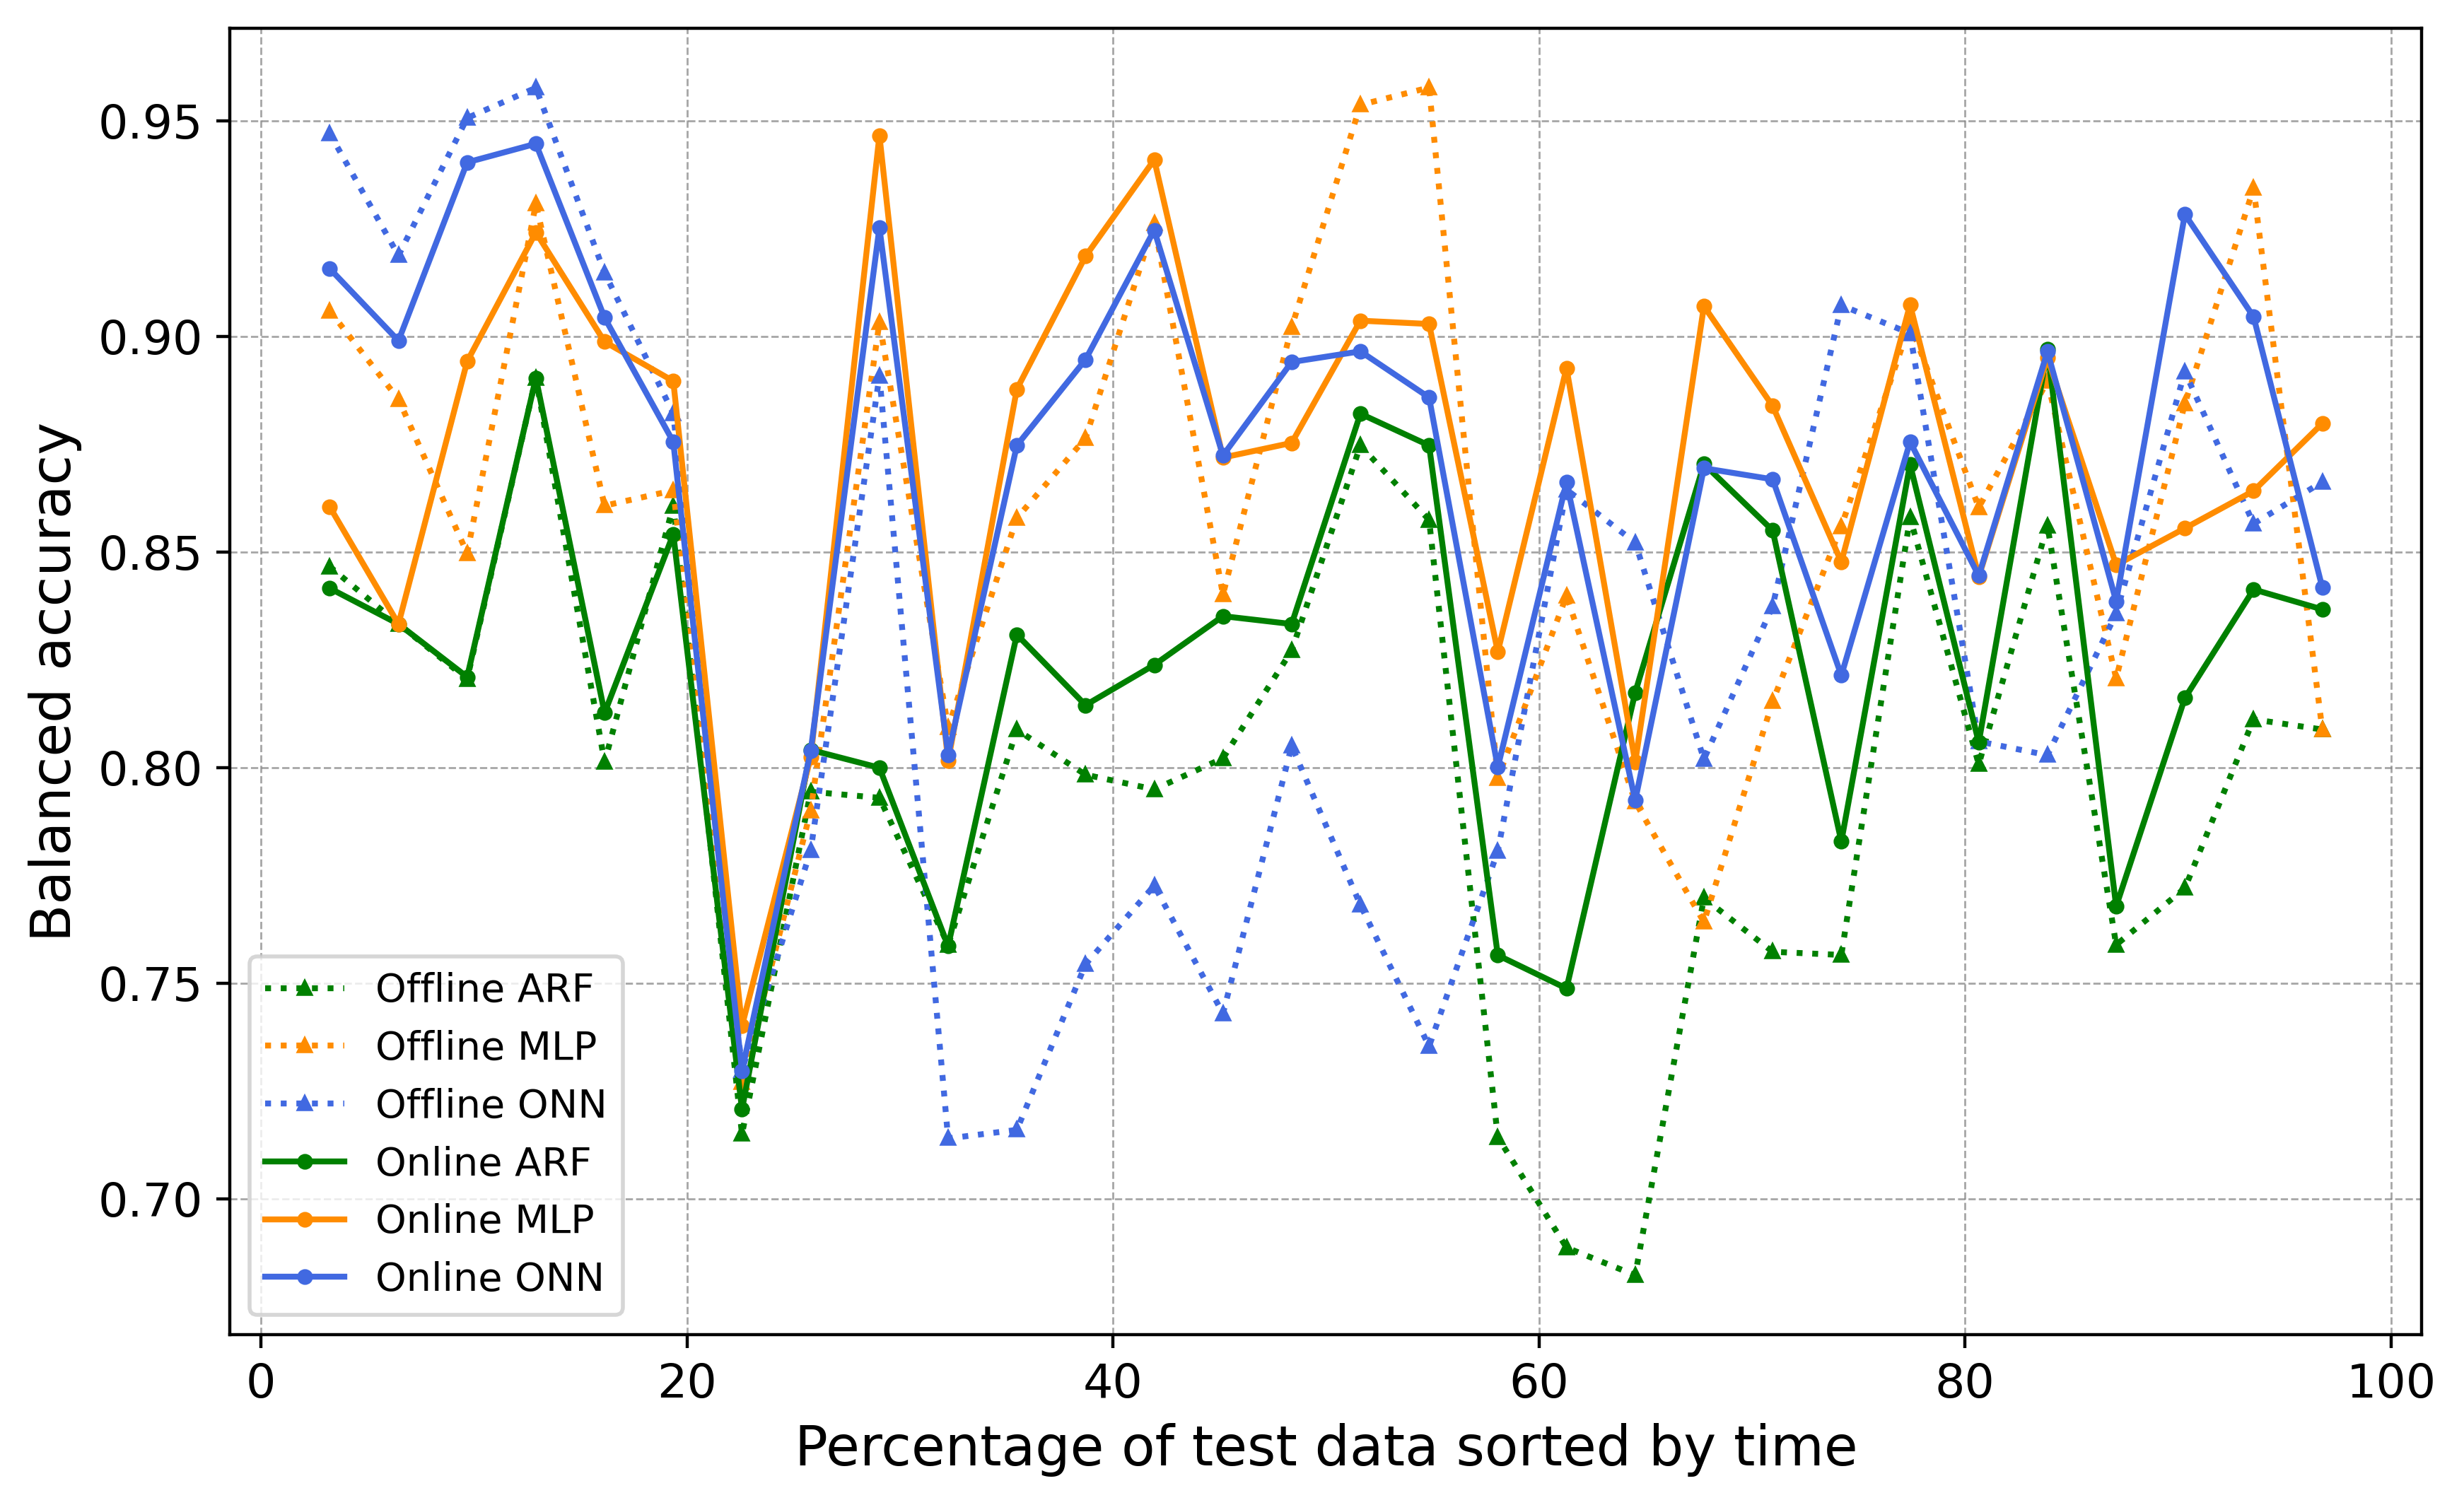

In [18]:
plt.figure(figsize=(10, 6), dpi = 400)

time_points = np.linspace(0, 100, 32)[1:-1]
plt.plot(time_points, offarf_acc_list, label='Offline ARF', color='green', marker='^', linestyle=':', linewidth=1.5, markersize=3)
plt.plot(time_points, offmlp_acc_list, label='Offline MLP', color='darkorange', marker='^', linestyle=':', linewidth=1.5, markersize=3)
plt.plot(time_points, offonn_acc_list, label='Offline ONN', color='royalblue', marker='^', linestyle=':', linewidth=1.5, markersize=3)
plt.plot(time_points, onarf_acc_list, label='Online ARF', color='green', marker='o', linestyle='-', linewidth=1.5, markersize=3)
plt.plot(time_points, onmlp_acc_list, label='Online MLP', color='darkorange', marker='o', linestyle='-', linewidth=1.5, markersize=3)
plt.plot(time_points, ononn_acc_list, label='Online ONN', color='royalblue', marker='o', linestyle='-', linewidth=1.5, markersize=3)

plt.xlabel('Percentage of test data sorted by time', fontsize=14)
plt.ylabel('Balanced accuracy', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='lower left', fontsize=10)

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

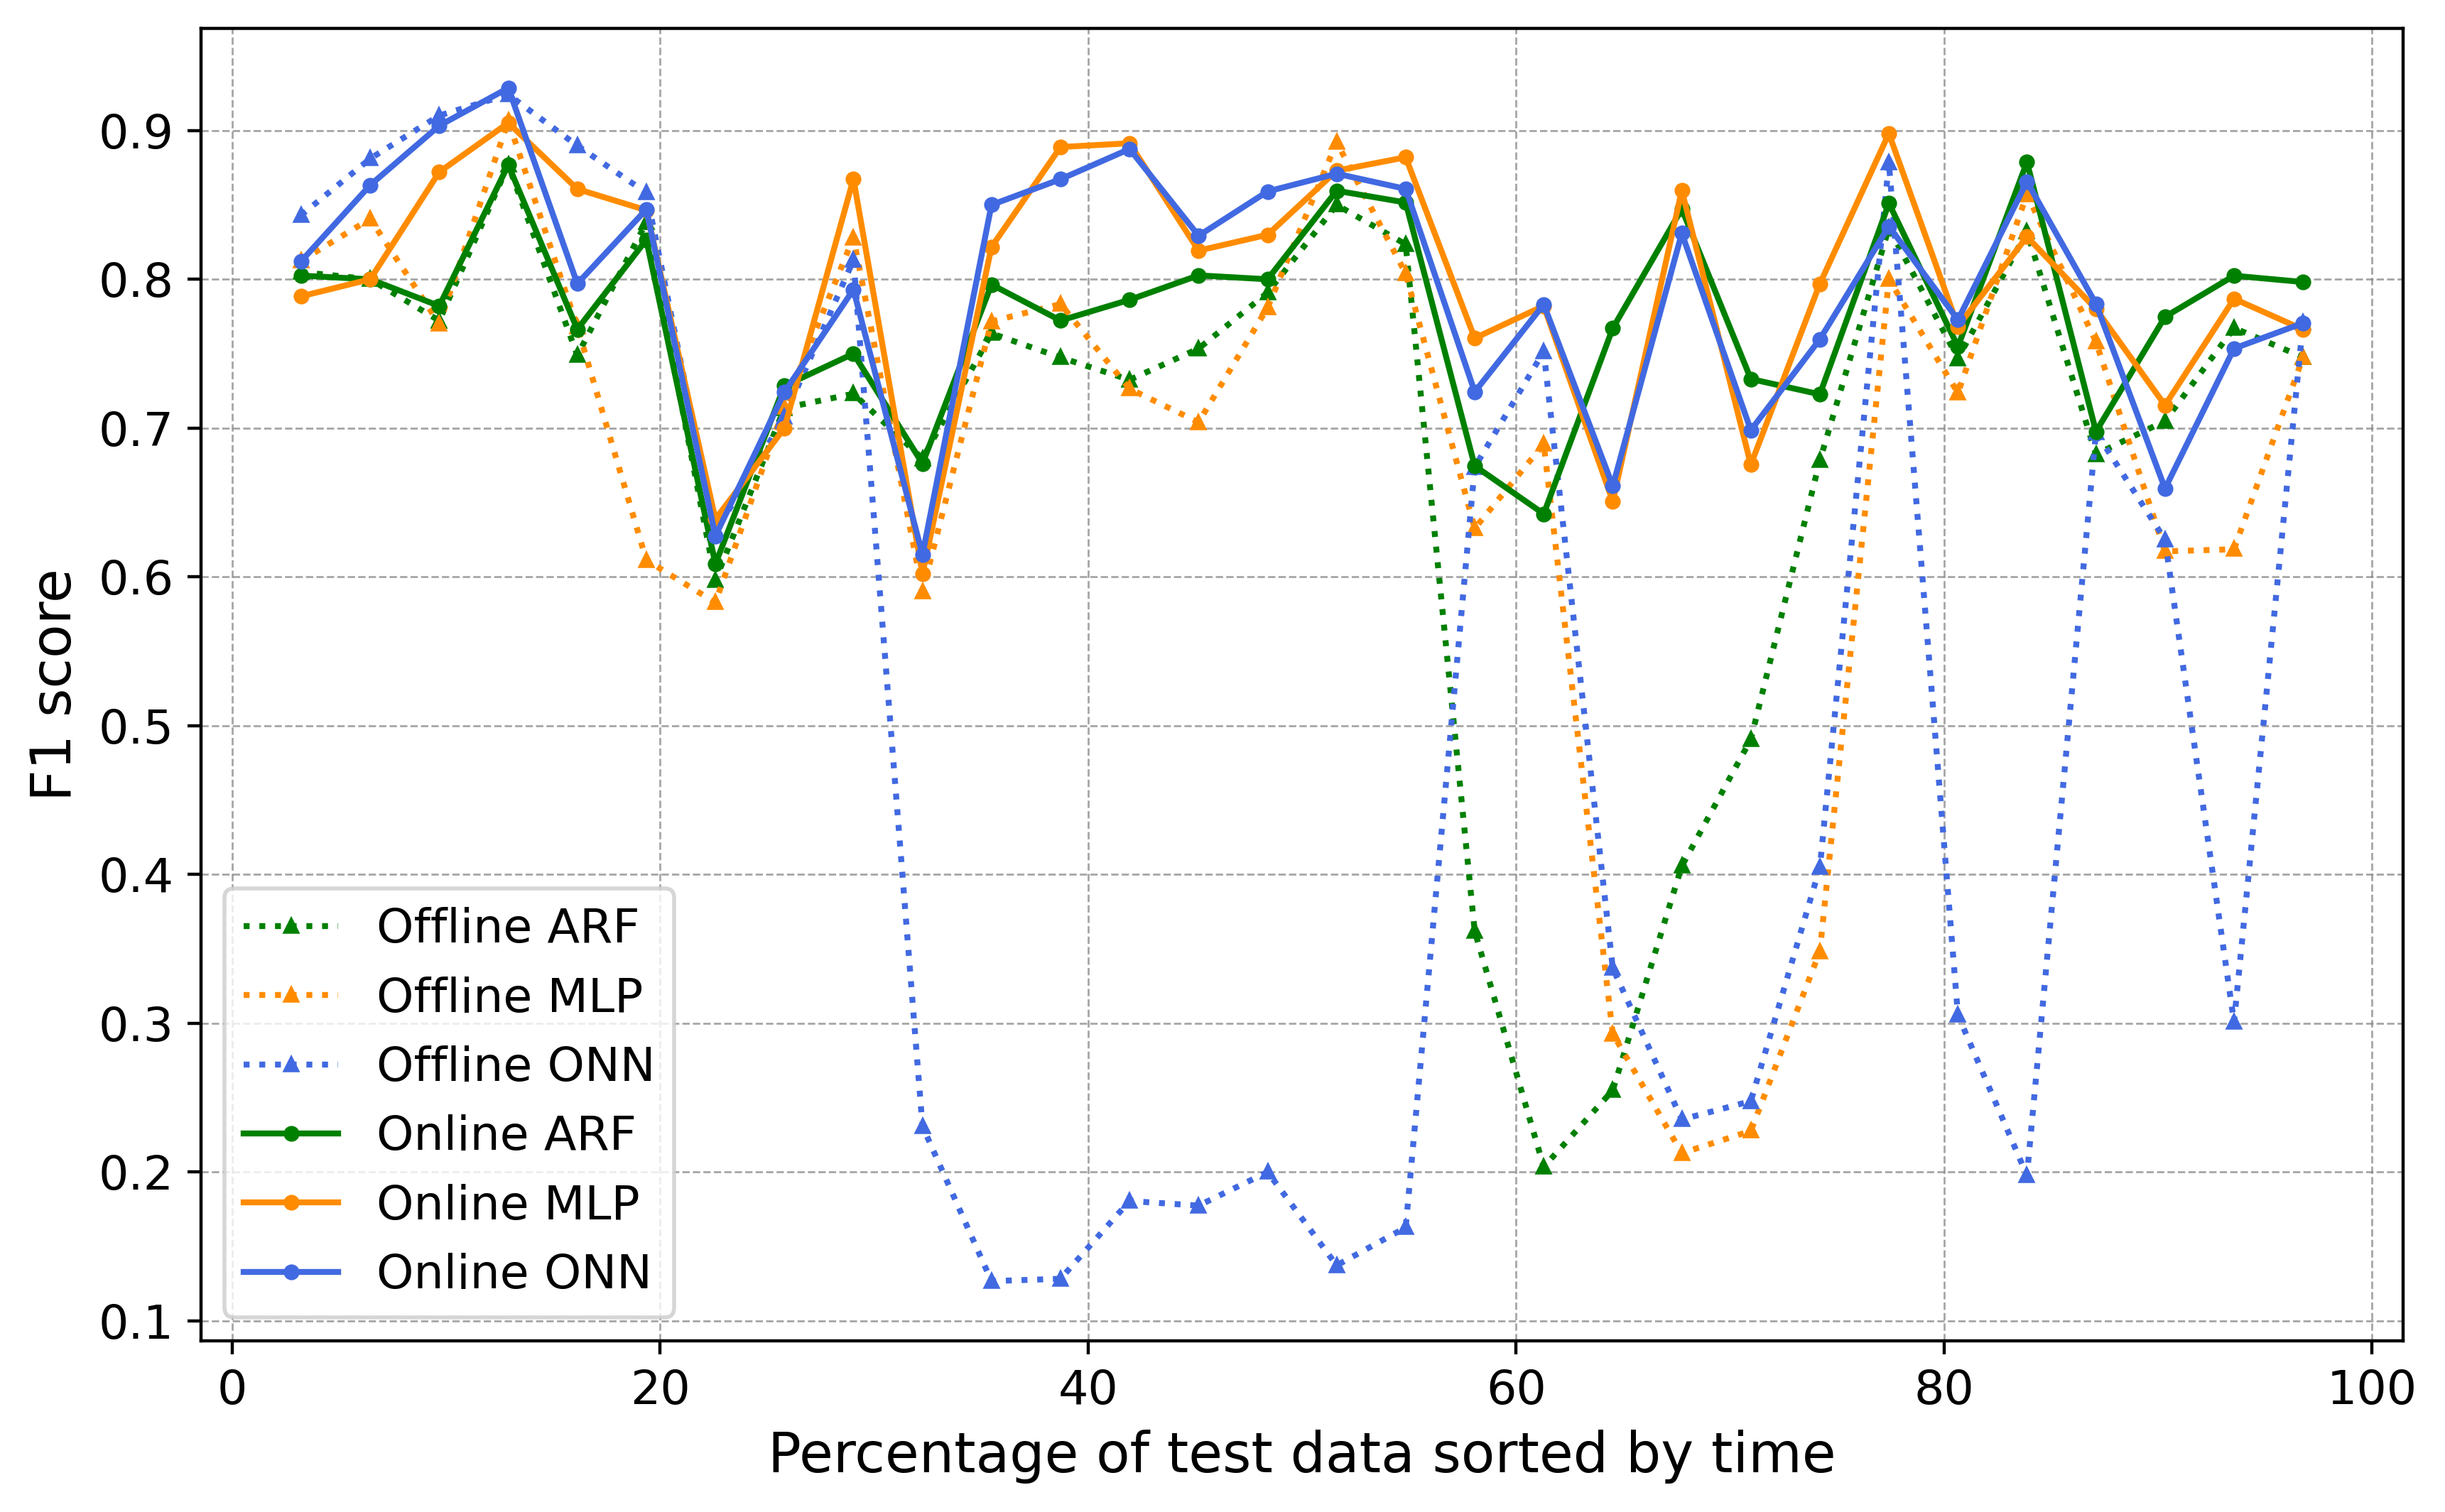

In [19]:
plt.figure(figsize=(10, 6), dpi = 400)

time_points = np.linspace(0, 100, 32)[1:-1]
plt.plot(time_points, offarf_f1_list, label='Offline ARF', color='green', marker='^', linestyle=':', linewidth=1.5, markersize=3)
plt.plot(time_points, offmlp_f1_list, label='Offline MLP', color='darkorange', marker='^', linestyle=':', linewidth=1.5, markersize=3)
plt.plot(time_points, offonn_f1_list, label='Offline ONN', color='royalblue', marker='^', linestyle=':', linewidth=1.5, markersize=3)
plt.plot(time_points, onarf_f1_list, label='Online ARF', color='green', marker='o', linestyle='-', linewidth=1.5, markersize=3)
plt.plot(time_points, onmlp_f1_list, label='Online MLP', color='darkorange', marker='o', linestyle='-', linewidth=1.5, markersize=3)
plt.plot(time_points, ononn_f1_list, label='Online ONN', color='royalblue', marker='o', linestyle='-', linewidth=1.5, markersize=3)

plt.xlabel('Percentage of test data sorted by time', fontsize=14)
plt.ylabel('F1 score', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='lower left', fontsize=12)

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

### Friedman test

In [45]:
ss.friedmanchisquare(*dict(total_f1_perf).values())

FriedmanchisquareResult(statistic=43.692528735632216, pvalue=2.6741280375338736e-08)

In [46]:
wide = total_f1_perf   # shape = [Chunk × models]
ss.friedmanchisquare(*[wide[col] for col in wide.columns])

FriedmanchisquareResult(statistic=43.692528735632216, pvalue=2.6741280375338736e-08)

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1fb59985790>)

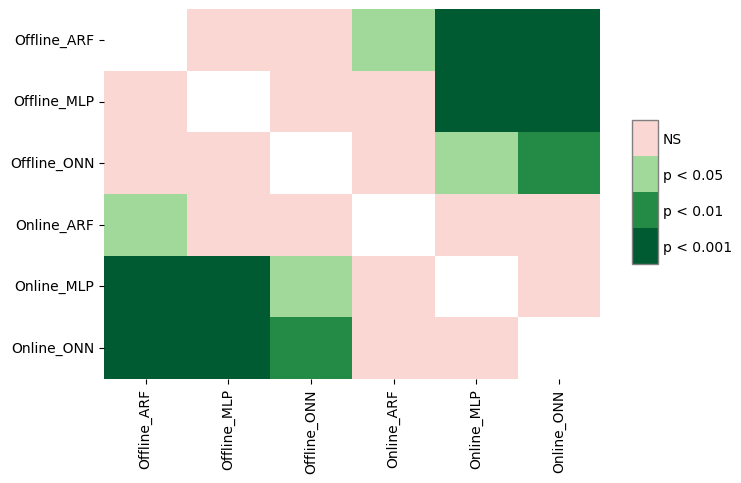

In [47]:
test_results = sp.posthoc_nemenyi_friedman(wide)
sp.sign_plot(test_results)

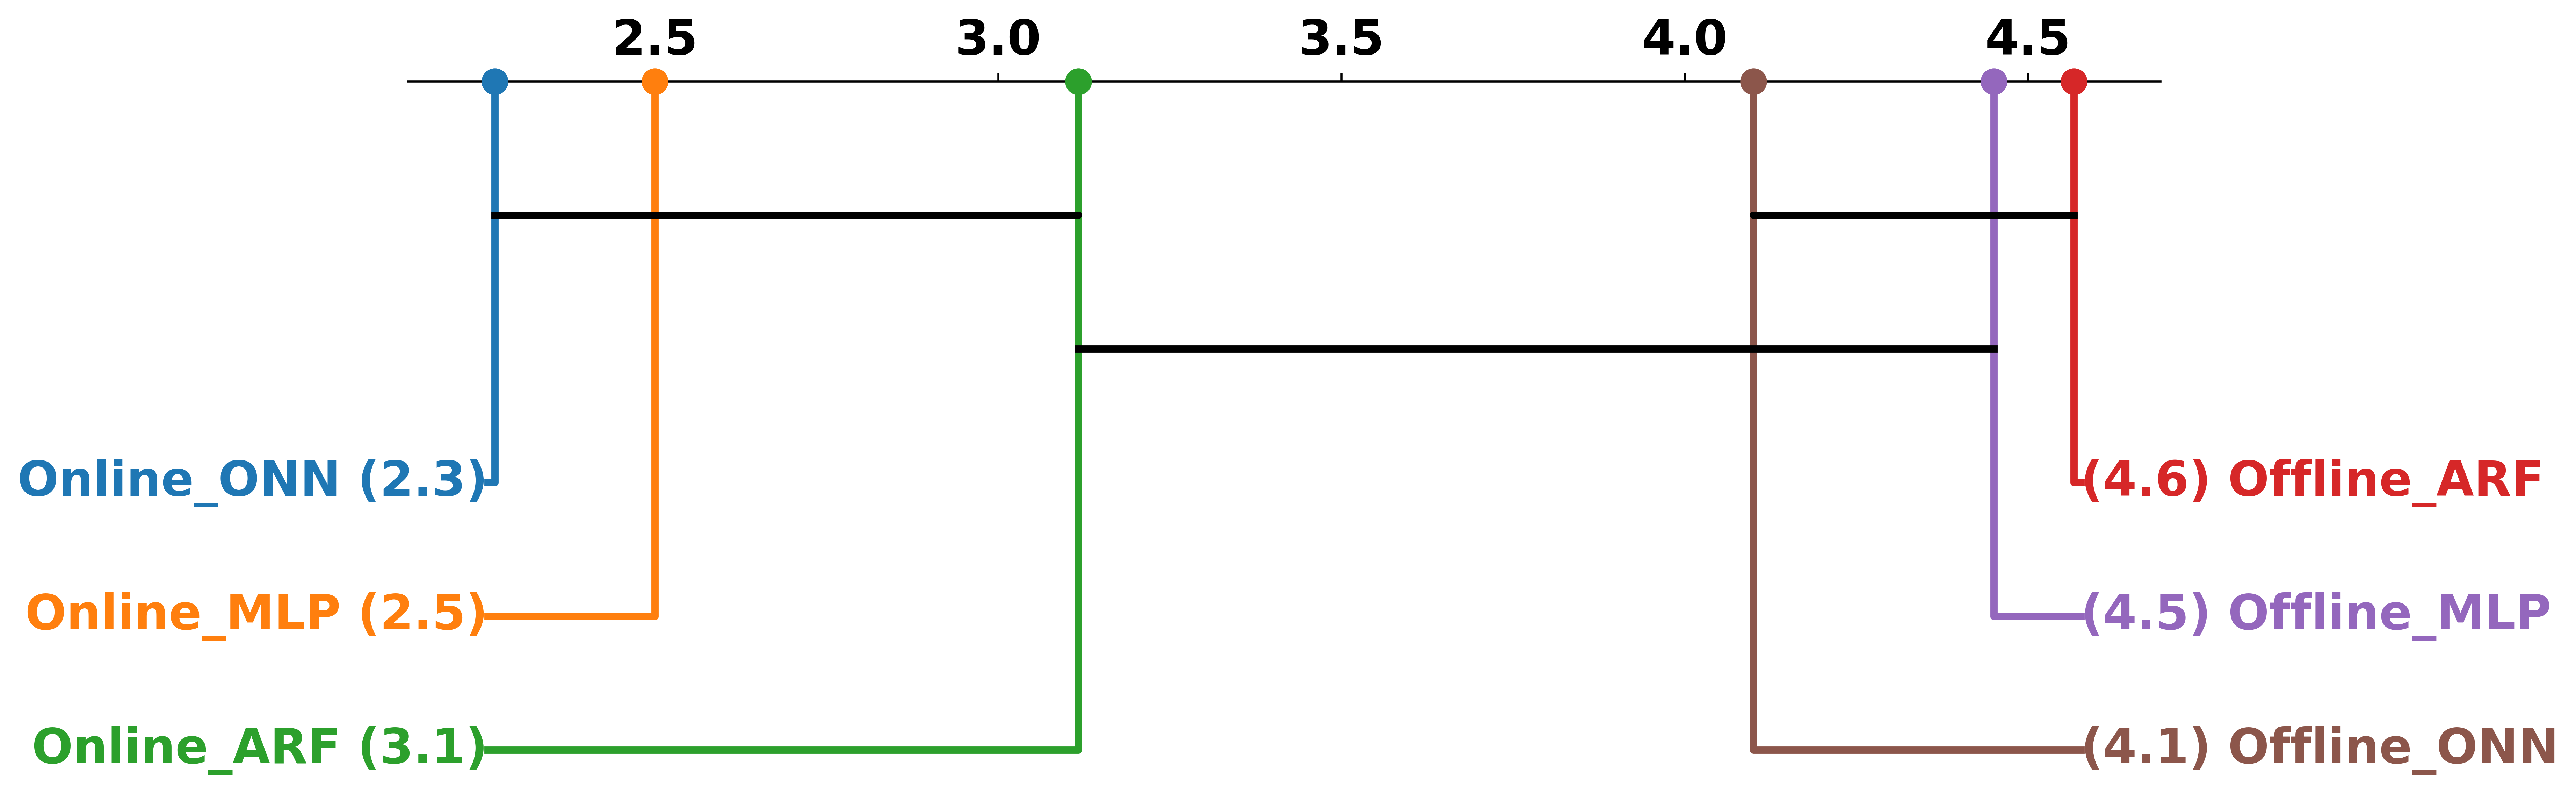

In [55]:
# wide-form total_f1_perf : shape = [Chunk × models]
rank_df = total_f1_perf.rank(axis=1, ascending=False)  # Chunk별 rank
avg_rank2 = rank_df.mean(axis=0)                       # model별 평균 rank

# model 순서 정렬
order = list(test_results.index)

avg_rank2 = avg_rank2.loc[order]
test_results = test_results.loc[order, order]

plt.figure(figsize=(15, 5), dpi=500)
plt.rcParams.update({'font.size': 20, 'font.weight': 'bold'})

sp.critical_difference_diagram(avg_rank2, test_results,elbow_props={'linewidth': 3},crossbar_props={'linewidth': 3}, marker_props={'s':100}  )
plt.tight_layout()
plt.show()

### Active learning

In [62]:
active_df = pd.read_csv('./test_results/result_active_learning.csv')
onn_df = pd.read_csv('./test_results/Online_ONN_results.csv')
active_df['100%'] = onn_df['Prediction']
display(active_df)

y_true  random_0.2  random_0.4  random_0.6  random_0.8  entropy_0.2  \
0         1.0           1           1           1           1            1   
1         1.0           1           1           1           1            1   
2         1.0           1           1           1           1            1   
3         1.0           1           1           1           1            1   
4         1.0           1           1           1           1            1   
...       ...         ...         ...         ...         ...          ...   
65236     0.0           0           0           0           0            0   
65237     0.0           0           0           0           0            0   
65238     0.0           0           0           0           0            0   
65239     0.0           0           0           0           0            0   
65240     0.0           0           0           0           0            0   

       entropy_0.4  entropy_0.6  entropy_0.8  kmeans_0.2  kmeans_0.4  \
0                1            1            1           1           1   
1                1            1            1           1           1   
2                1            1            1           1           1   
3                1            1            1           1           1   
4                1            1            1           1           1   
...            ...          ...          ...         ...         ...   
65236            0            0            0           0           0   
65237            0            0            0           0           0   
65238            0            0            0           0           0   
65239            0            0            0           0           0   
65240            0            0            0           0           0   

       kmeans_0.6  kmeans_0.8  100%  
0               1           1     1  
1               1           1     1  
2               1           1     1  
3               1           1     1  
4               1           1     1  
...           ...         ...   ...  
65236           0           0     0  
65237           0           0     0  
65238           0           0     0  
65239           0           0     0  
65240           0           0     0  

[65241 rows x 14 columns]

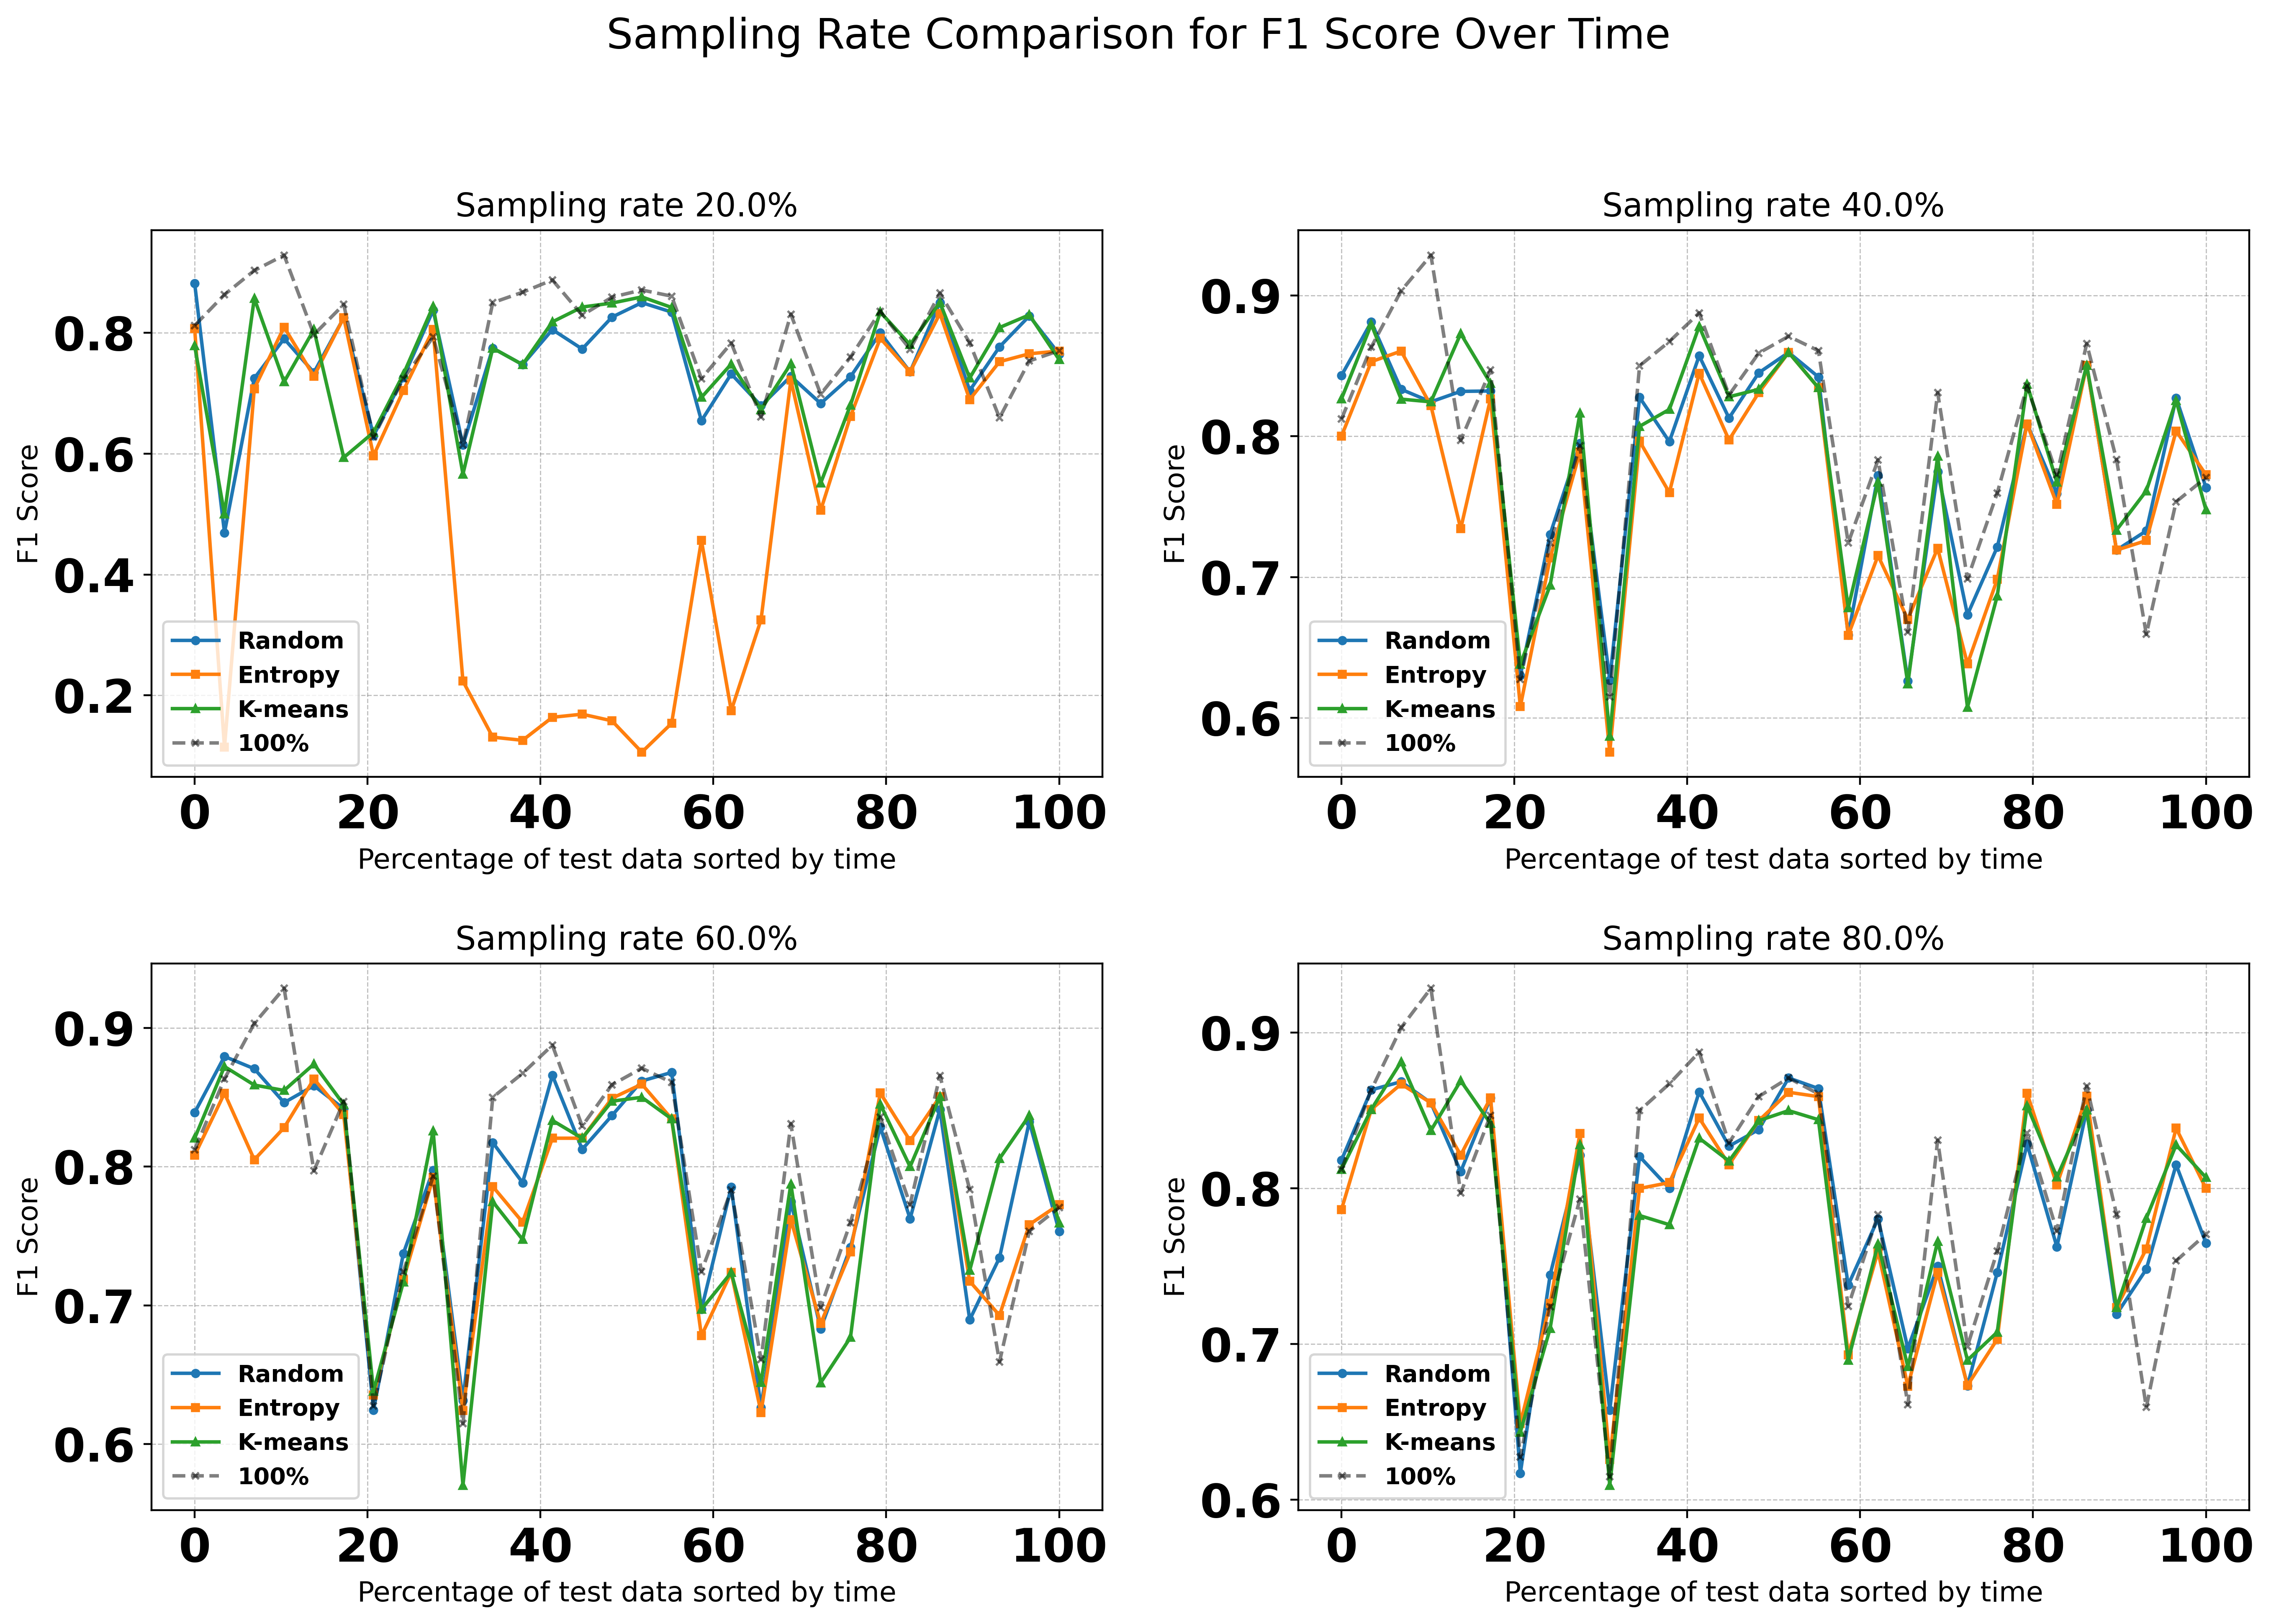

In [63]:
def AL_vis_multiple_ratios(active_df, ratios):
    chunk_num = 30
    chunk_size = len(active_df) // chunk_num

    fig, axs = plt.subplots(2, 2, figsize=(14, 10), dpi=400)
    fig.suptitle("Sampling Rate Comparison for F1 Score Over Time", fontsize=18)
    time_points = np.linspace(0, 100, chunk_num)
    positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for idx, ratio in enumerate(ratios):
        rand_f1_list = []
        ent_f1_list = []
        kmeans_f1_list = []
        upper_f1_list = []

        for i in range(chunk_num):
            start_idx = i * chunk_size
            end_idx = (i + 1) * chunk_size
            if i == (chunk_num - 1):
                chunk_y = active_df.loc[start_idx:, 'y_true']
                chunk_pred_rand = active_df.loc[start_idx:, f'random_{ratio}']
                chunk_pred_ent = active_df.loc[start_idx:, f'entropy_{ratio}']
                chunk_pred_kmeans = active_df.loc[start_idx:, f'kmeans_{ratio}']
                chunk_pred_upper = active_df.loc[start_idx:, f'100%']
            else:
                chunk_y = active_df.loc[start_idx:end_idx, 'y_true']
                chunk_pred_rand = active_df.loc[start_idx:end_idx, f'random_{ratio}']
                chunk_pred_ent = active_df.loc[start_idx:end_idx, f'entropy_{ratio}']
                chunk_pred_kmeans = active_df.loc[start_idx:end_idx, f'kmeans_{ratio}']
                chunk_pred_upper = active_df.loc[start_idx:end_idx, f'100%']

            rand_f1_list.append(f1_score(chunk_y, chunk_pred_rand))
            ent_f1_list.append(f1_score(chunk_y, chunk_pred_ent))
            kmeans_f1_list.append(f1_score(chunk_y, chunk_pred_kmeans))
            upper_f1_list.append(f1_score(chunk_y, chunk_pred_upper))

        ax = axs[positions[idx]]
        ax.plot(time_points, rand_f1_list, label='Random', color='tab:blue', marker='o', linestyle='-', linewidth=1.5, markersize=3, alpha=1)
        ax.plot(time_points, ent_f1_list, label='Entropy', color='tab:orange', marker='s', linestyle='-', linewidth=1.5, markersize=3, alpha=1)
        ax.plot(time_points, kmeans_f1_list, label='K-means', color='tab:green', marker='^', linestyle='-', linewidth=1.5, markersize=3, alpha=1)
        ax.plot(time_points, upper_f1_list, label='100%', color='black', marker='x', linestyle='--', linewidth=1.5, markersize=3, alpha=0.5)

        ax.set_title(f'Sampling rate {str(ratio * 100)}%', fontsize=14)
        ax.set_xlabel('Percentage of test data sorted by time', fontsize=12)
        ax.set_ylabel('F1 Score', fontsize=12)
        ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.legend(loc='lower left', fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

ratios = [0.2, 0.4, 0.6, 0.8]
AL_vis_multiple_ratios(active_df, ratios)


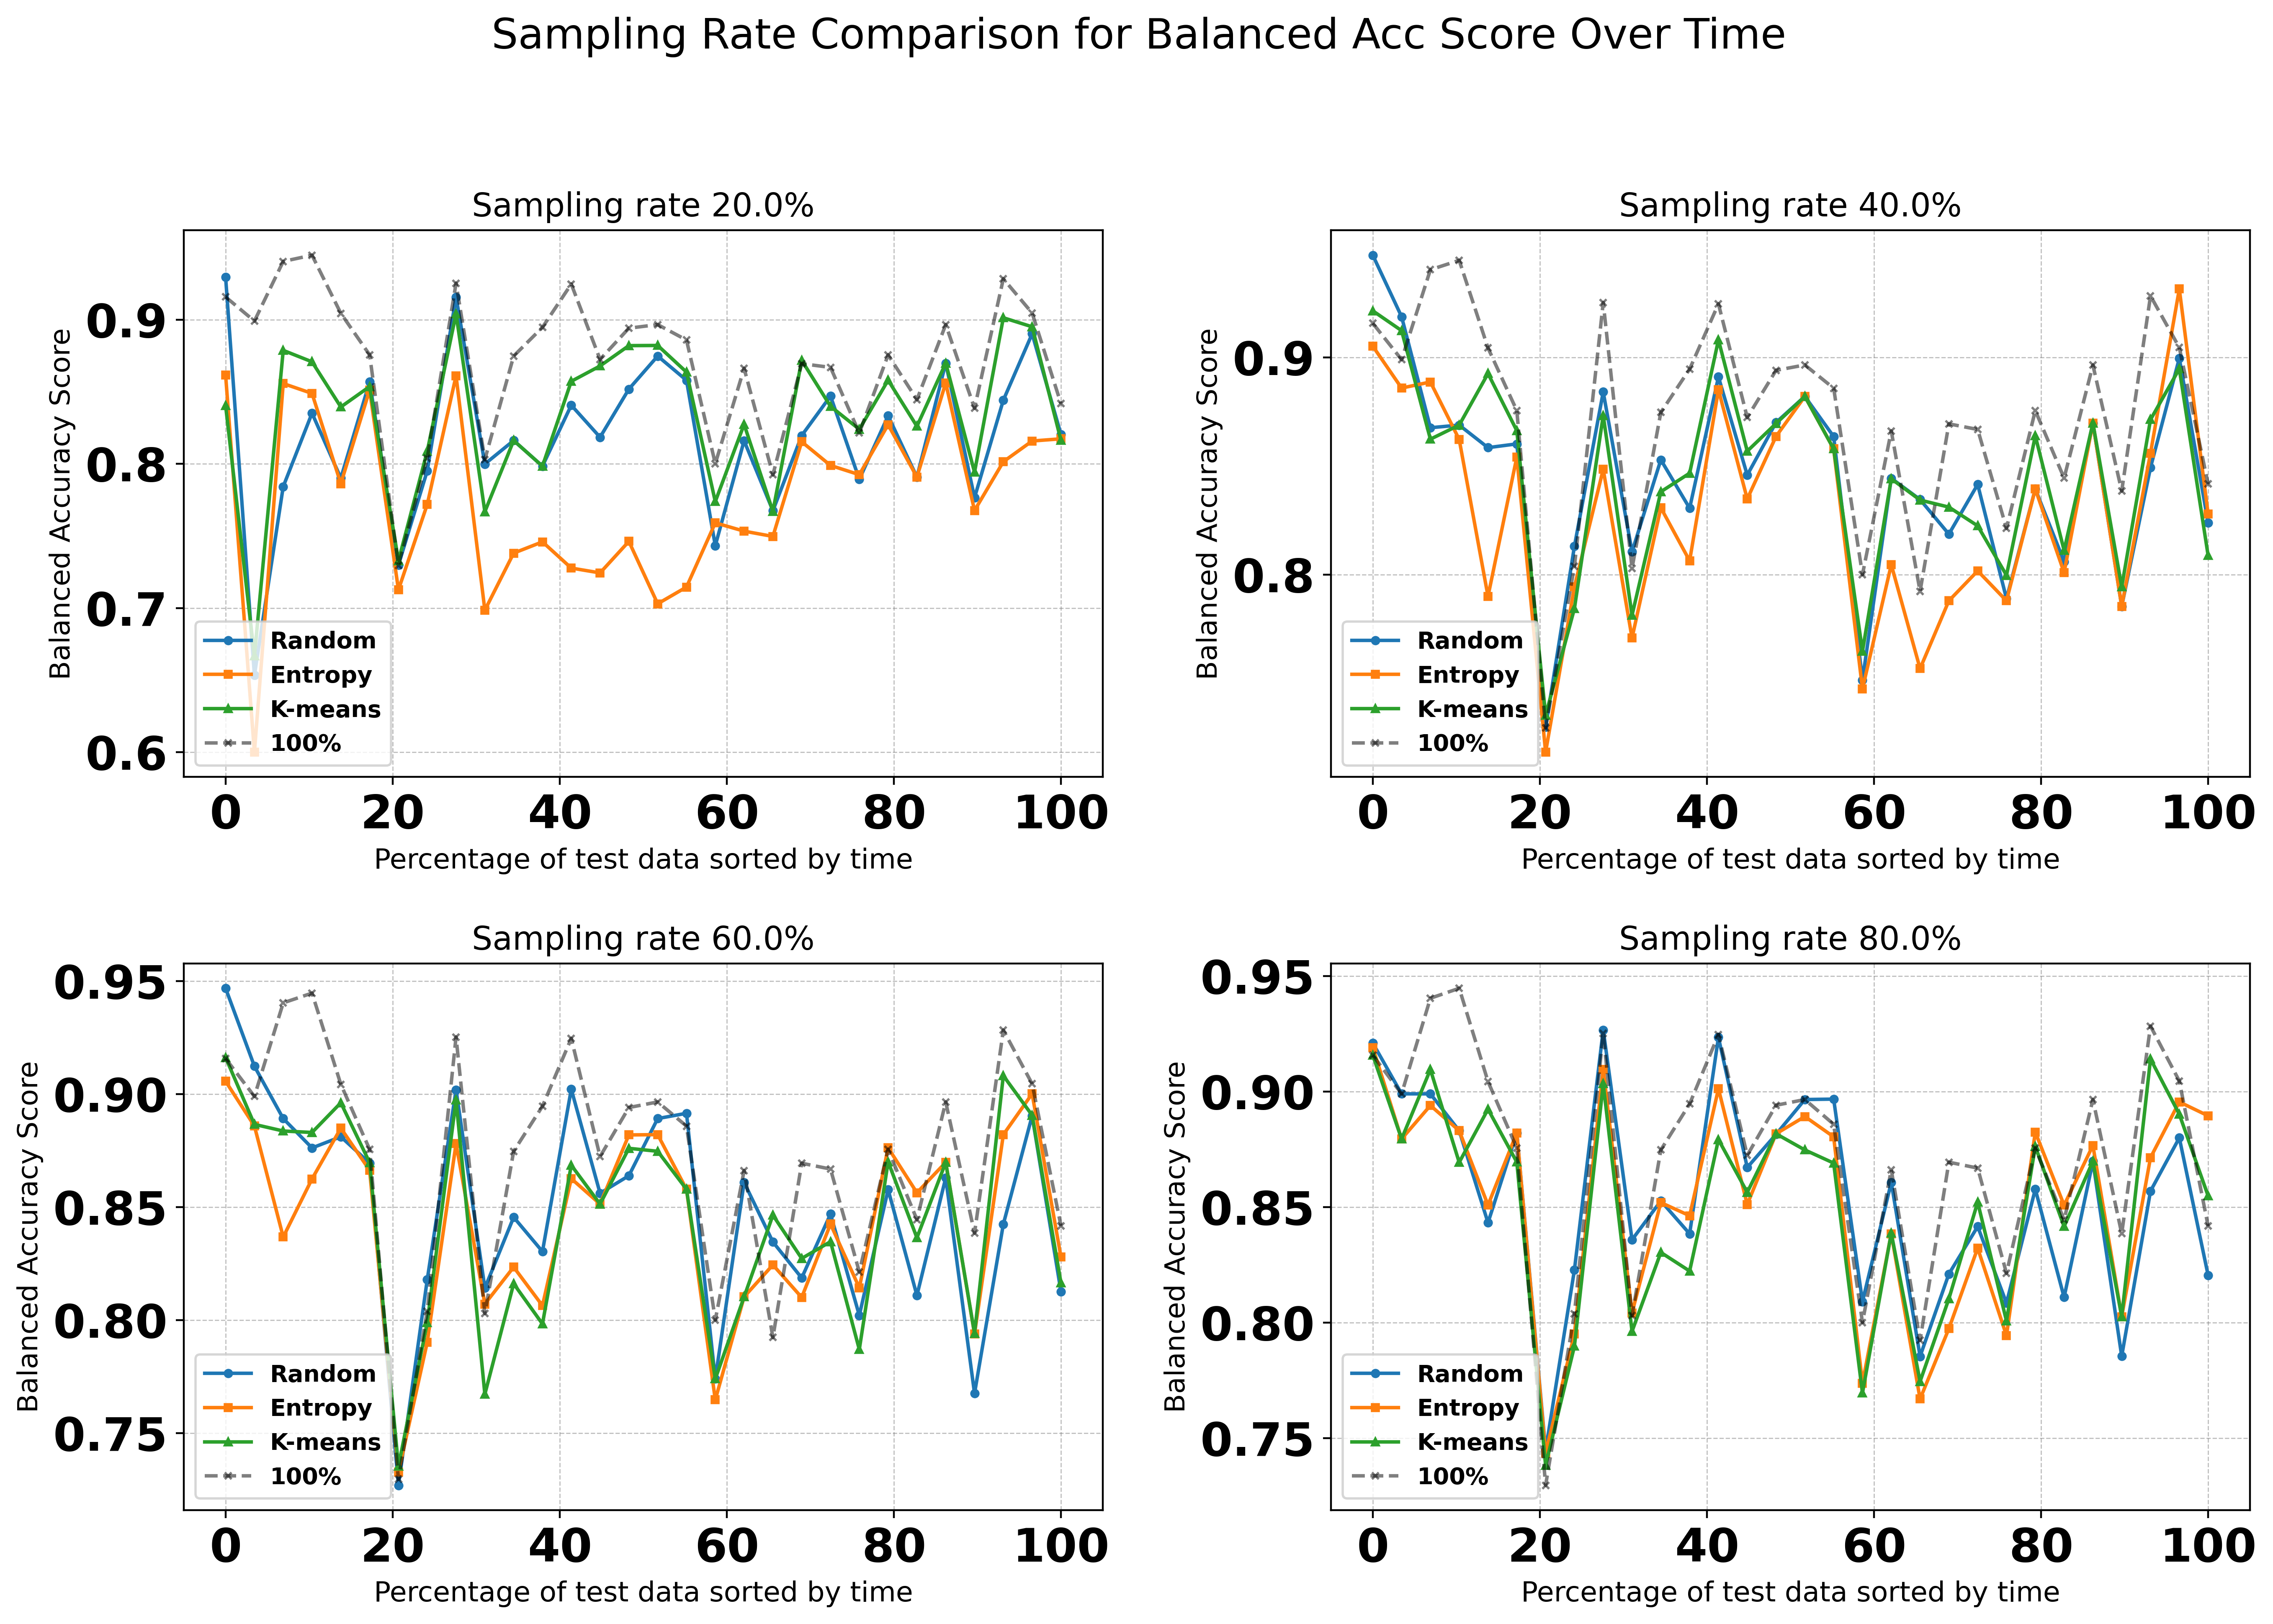

In [64]:
def AL_vis_acc_multiple_ratios(active_df, ratios):
    chunk_num = 30
    chunk_size = len(active_df) // chunk_num

    fig, axs = plt.subplots(2, 2, figsize=(14, 10), dpi=400)
    fig.suptitle("Sampling Rate Comparison for Balanced Acc Score Over Time", fontsize=18)

    time_points = np.linspace(0, 100, chunk_num)
    positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for idx, ratio in enumerate(ratios):
        rand_acc_list = []
        ent_acc_list = []
        kmeans_acc_list = []
        upper_acc_list = []

        for i in range(chunk_num):
            start_idx = i * chunk_size
            end_idx = (i + 1) * chunk_size
            if i == (chunk_num - 1):
                chunk_y = active_df.loc[start_idx:, 'y_true']
                chunk_pred_rand = active_df.loc[start_idx:, f'random_{ratio}']
                chunk_pred_ent = active_df.loc[start_idx:, f'entropy_{ratio}']
                chunk_pred_kmeans = active_df.loc[start_idx:, f'kmeans_{ratio}']
                chunk_pred_upper = active_df.loc[start_idx:, f'100%']
            else:
                chunk_y = active_df.loc[start_idx:end_idx, 'y_true']
                chunk_pred_rand = active_df.loc[start_idx:end_idx, f'random_{ratio}']
                chunk_pred_ent = active_df.loc[start_idx:end_idx, f'entropy_{ratio}']
                chunk_pred_kmeans = active_df.loc[start_idx:end_idx, f'kmeans_{ratio}']
                chunk_pred_upper = active_df.loc[start_idx:end_idx, f'100%']

            # Append scores, or np.nan if the length is zero
            rand_acc_list.append(balanced_accuracy_score(chunk_y, chunk_pred_rand) if len(chunk_y) > 0 else np.nan)
            ent_acc_list.append(balanced_accuracy_score(chunk_y, chunk_pred_ent) if len(chunk_y) > 0 else np.nan)
            kmeans_acc_list.append(balanced_accuracy_score(chunk_y, chunk_pred_kmeans) if len(chunk_y) > 0 else np.nan)
            upper_acc_list.append(balanced_accuracy_score(chunk_y, chunk_pred_upper) if len(chunk_y) > 0 else np.nan)

        ax = axs[positions[idx]]
        ax.plot(time_points, rand_acc_list, label='Random', color='tab:blue', marker='o', linestyle='-', linewidth=1.5, markersize=3, alpha=1)
        ax.plot(time_points, ent_acc_list, label='Entropy', color='tab:orange', marker='s', linestyle='-', linewidth=1.5, markersize=3, alpha=1)
        ax.plot(time_points, kmeans_acc_list, label='K-means', color='tab:green', marker='^', linestyle='-', linewidth=1.5, markersize=3, alpha=1)
        ax.plot(time_points, upper_acc_list, label='100%', color='black', marker='x', linestyle='--', linewidth=1.5, markersize=3, alpha=0.5)

        ax.set_title(f'Sampling rate {str(ratio * 100)}%', fontsize=14)
        ax.set_xlabel('Percentage of test data sorted by time', fontsize=12)
        ax.set_ylabel('Balanced Accuracy Score', fontsize=12)
        ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.legend(loc='lower left', fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

ratios = [0.2, 0.4, 0.6, 0.8]
AL_vis_acc_multiple_ratios(active_df, ratios)